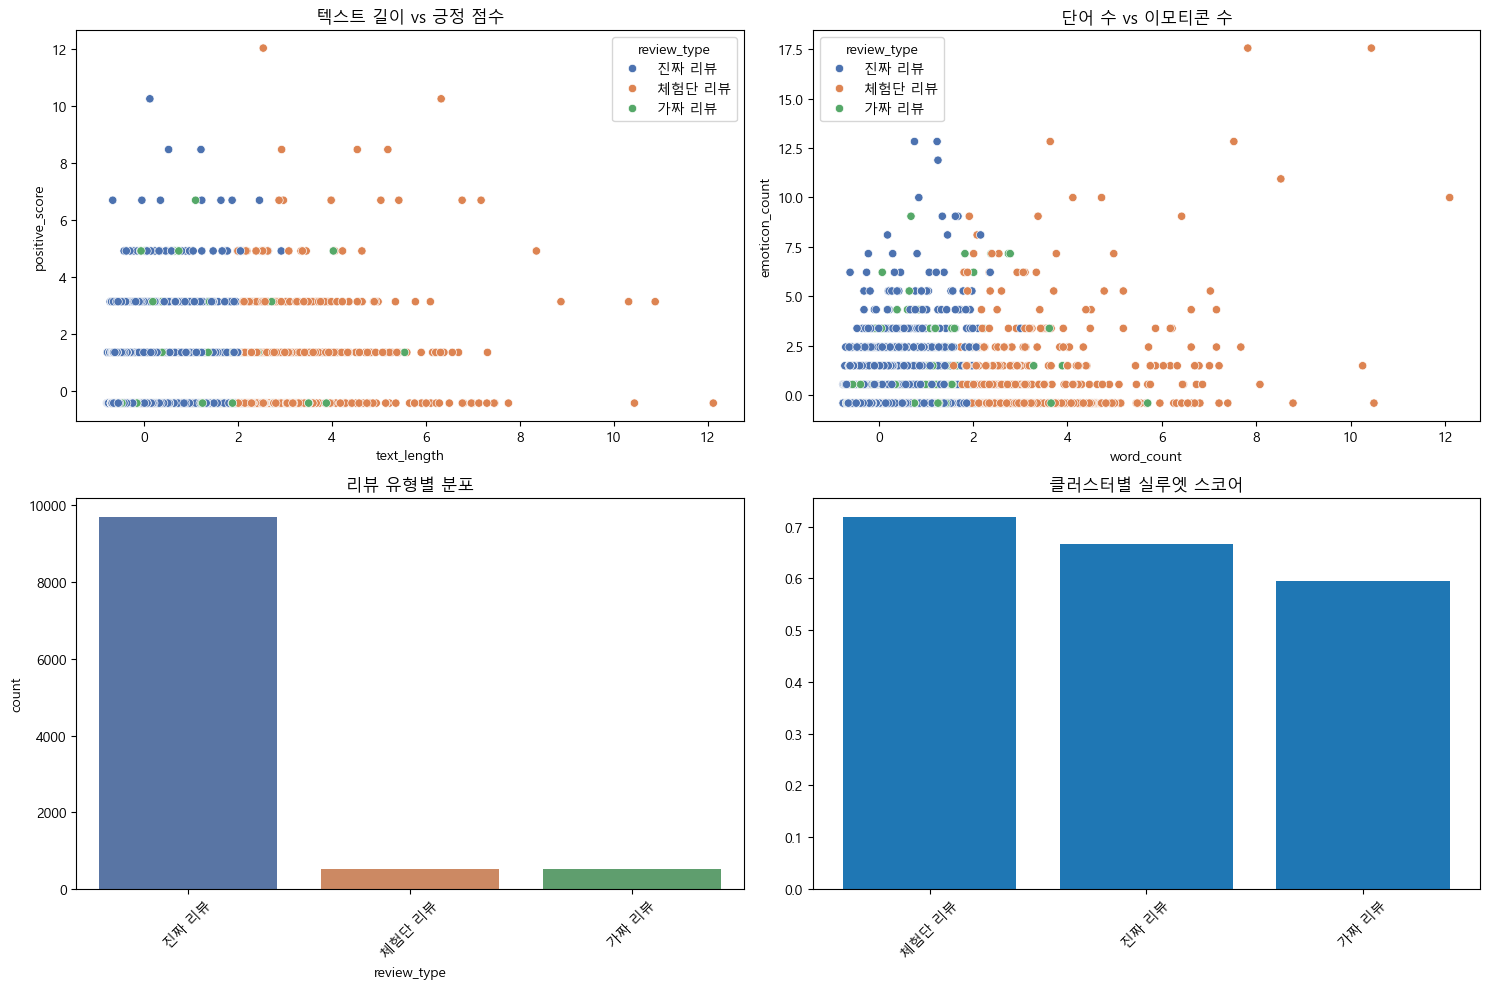


진짜 리뷰 분석:
리뷰 수: 9698
평균 텍스트 길이: -0.20
평균 긍정 점수: -0.06
평균 이모티콘 수: -0.06

체험단 리뷰 분석:
리뷰 수: 531
평균 텍스트 길이: 3.37
평균 긍정 점수: 1.02
평균 이모티콘 수: 0.90

가짜 리뷰 분석:
리뷰 수: 525
평균 텍스트 길이: 0.22
평균 긍정 점수: 0.06
평균 이모티콘 수: 0.21

저장된 데이터 정보:
전체 데이터 수: 10754

리뷰 유형별 데이터 수:
review_type
진짜 리뷰     9698
체험단 리뷰     531
가짜 리뷰      525
Name: count, dtype: int64

저장된 파일명: labeled_reviews.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib as mpl

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False


# 데이터 로드
df = pd.read_csv('cleaned_reviews_for_learning.csv', encoding='utf-8-sig')
df = df.dropna(subset=['text'])

# 특성 정의
def get_review_characteristics(row):
    # 텍스트 길이 기준
    if row['text_length'] > 4.0:
        length_score = 2  # 매우 긴 텍스트
    elif row['text_length'] > 2.0:
        length_score = 1  # 적절한 길이
    else:
        length_score = 0  # 짧은 텍스트
    
    # 감성 점수 균형
    sentiment_balance = abs(row['positive_score'] - row['negative_score'])
    if sentiment_balance > 5.0:
        sentiment_score = 0  # 매우 편향된 감정
    else:
        sentiment_score = 1  # 균형잡힌 감정
    
    # 이모티콘 사용
    if row['emoticon_count'] > 3:
        emoticon_score = 0  # 과도한 이모티콘
    else:
        emoticon_score = 1  # 적절한 이모티콘
        
    return length_score + sentiment_score + emoticon_score

# 특성 점수 계산
df['review_score'] = df.apply(get_review_characteristics, axis=1)

# 클러스터링을 위한 특성 준비
features = ['text_length', 'word_count', 'emoticon_count', 
           'positive_score', 'negative_score', 'review_score']
X = StandardScaler().fit_transform(df[features])

# K-means 클러스터링 (3개 클러스터)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # n_init 명시적 지정

df['cluster'] = kmeans.fit_predict(X)

# 클러스터 라벨링
cluster_labels = {
    0: '체험단 리뷰',  # 긴 텍스트, 매우 긍정적
    1: '진짜 리뷰',    # 중간 길이, 균형잡힌 감정
    2: '가짜 리뷰'     # 짧은 텍스트, 과도하게 긍정적
}
df['review_type'] = df['cluster'].map(cluster_labels)

# 클러스터별 실루엣 스코어 계산 수정
silhouette_scores = []
cluster_names = []
for i in range(3):
    cluster_mask = df['cluster'] == i
    cluster_data = X[cluster_mask]
    if len(cluster_data) > 1:
        # 전체 데이터셋에 대해 해당 클러스터의 실루엣 스코어 계산
        labels = np.zeros(len(df['cluster']))
        labels[cluster_mask] = 1
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        cluster_names.append(cluster_labels[i])

# 시각화
plt.figure(figsize=(15, 10))

# 텍스트 길이와 감성 점수 산점도
plt.subplot(221)
sns.scatterplot(data=df, x='text_length', y='positive_score', 
                hue='review_type', palette='deep')
plt.title('텍스트 길이 vs 긍정 점수')

# 단어 수와 이모티콘 수 산점도
plt.subplot(222)
sns.scatterplot(data=df, x='word_count', y='emoticon_count', 
                hue='review_type', palette='deep')
plt.title('단어 수 vs 이모티콘 수')

# 클러스터별 분포
plt.subplot(223)
sns.countplot(data=df, x='review_type', hue='review_type', legend=False, palette='deep')
plt.xticks(rotation=45)
plt.title('리뷰 유형별 분포')

# 클러스터별 실루엣 스코어 시각화 수정
plt.subplot(224)
plt.bar(cluster_names, silhouette_scores)
plt.title('클러스터별 실루엣 스코어')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 클러스터별 통계 출력
for cluster in df['review_type'].unique():
    cluster_data = df[df['review_type'] == cluster]
    print(f"\n{cluster} 분석:")
    print(f"리뷰 수: {len(cluster_data)}")
    print(f"평균 텍스트 길이: {cluster_data['text_length'].mean():.2f}")
    print(f"평균 긍정 점수: {cluster_data['positive_score'].mean():.2f}")
    print(f"평균 이모티콘 수: {cluster_data['emoticon_count'].mean():.2f}")


# 클러스터링 결과를 새로운 CSV 파일로 저장
df.to_csv('labeled_reviews.csv', encoding='utf-8-sig', index=False)

# 저장 결과 확인
print("\n저장된 데이터 정보:")
print(f"전체 데이터 수: {len(df)}")
print("\n리뷰 유형별 데이터 수:")
print(df['review_type'].value_counts())
print("\n저장된 파일명: labeled_reviews.csv")
